## Fall 2023 EE541 Final Project

Dinglun Zhang & Zhanqin Ai

Prof. Brandon Franzke

12/7/2023  


Epoch: 1,Train Loss: 1.0159,Train Accuracy: 69.6908%,Validation Loss: 0.3467,Validation Accuracy: 88.9885%
Epoch: 2,Train Loss: 0.2376,Train Accuracy: 92.4350%,Validation Loss: 0.1883,Validation Accuracy: 94.0766%
Epoch: 3,Train Loss: 0.1304,Train Accuracy: 95.7356%,Validation Loss: 0.1403,Validation Accuracy: 95.8008%
Epoch: 4,Train Loss: 0.0869,Train Accuracy: 97.2233%,Validation Loss: 0.1147,Validation Accuracy: 96.5517%
Epoch: 5,Train Loss: 0.0667,Train Accuracy: 97.8423%,Validation Loss: 0.1061,Validation Accuracy: 96.7203%
Epoch: 6,Train Loss: 0.0509,Train Accuracy: 98.3054%,Validation Loss: 0.1084,Validation Accuracy: 96.7969%
Epoch: 7,Train Loss: 0.0437,Train Accuracy: 98.5928%,Validation Loss: 0.0909,Validation Accuracy: 97.5709%
Epoch: 8,Train Loss: 0.0396,Train Accuracy: 98.7290%,Validation Loss: 0.1039,Validation Accuracy: 97.1418%
Epoch: 9,Train Loss: 0.0372,Train Accuracy: 98.8177%,Validation Loss: 0.1247,Validation Accuracy: 96.5211%
Epoch: 10,Train Loss: 0.0266,Train Ac

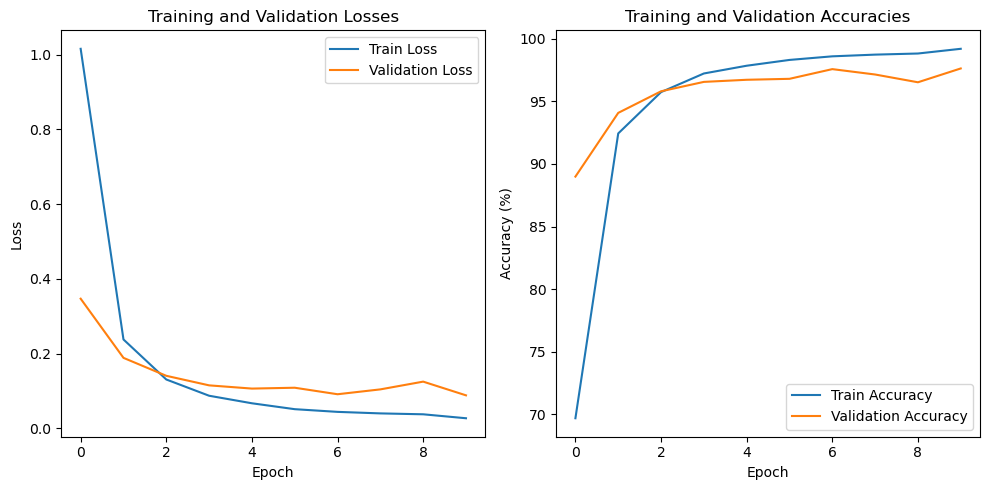

Test Accuracy: 97.53275611064286%


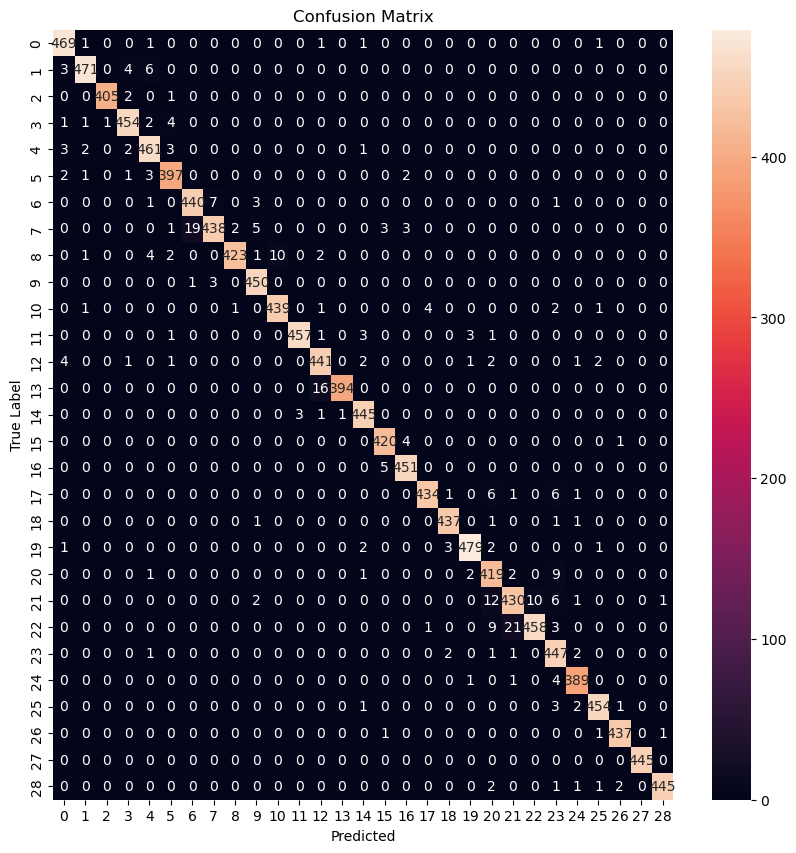

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformation and augmentation
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and split the dataset with ratio (70 : 15 : 15)
dataset = datasets.ImageFolder('./asl_alphabet_train/asl_alphabet_train', transform=transform)

train_size = int(0.7 * len(dataset))
validation_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model architecture
# Two convolutional layers that preserve the input size (K=3, P=1, S=1, Y=[(W−K+2P)/S]+1=W)
# Each follow by a max pooling layer that halves the size of the input size.
# One droupout layer with rate 0.3 and one fully-connected layer.
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*50*50, 29)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)

        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

model = SignLanguageModel().to(device)

# Loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

# Helper function to calculate accuracy
def calculate_accuracy(output, labels):
    _, predicted = torch.max(output.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct, total

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct, total = calculate_accuracy(output, labels)
        train_correct += correct
        train_total += total

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / train_total * 100)
    
    # Validation
    model.eval()
    validation_loss = 0.0
    validation_correct = 0
    validation_total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_func(output, labels)
            validation_loss += loss.item()
            correct, total = calculate_accuracy(output, labels)
            validation_correct += correct
            validation_total += total

    validation_losses.append(validation_loss / len(validation_loader))
    validation_accuracies.append(validation_correct / validation_total * 100)

    print(f'Epoch: {epoch+1}, '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracies[-1]:.4f}%, '
          f'Validation Loss: {validation_losses[-1]:.4f}, '
          f'Validation Accuracy: {validation_accuracies[-1]:.4f}%')

# Plot learning curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Testing
model.eval()
test_correct = 0
test_total = 0

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        correct, total = calculate_accuracy(output, labels)
        test_correct += correct
        test_total += total

        all_predictions.extend(torch.argmax(output, 1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total * 100
print(f'Test Accuracy: {test_accuracy}%')

# Plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()
